# Section 1: Pytorch Tensors

Neural network computations are just a bunch of linear algebra operations on *tensors*, a generalization of matrices. A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices is a 3-dimensional tensor (RGB color images for example). The fundamental data structure for neural networks are tensors and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.

<center><img src="assets/tensor_examples.svg" width=1000px></center>


In [37]:
import torch
L = [[1, 2], [3,4]]
torch.tensor(L)

tensor([[1, 2],
        [3, 4]])


## Numpy to Torch and back

PyTorch has a great feature for converting between Numpy arrays and Torch tensors. To create a tensor from a Numpy array, use `torch.from_numpy()`. To convert a tensor to a Numpy array, use the `.numpy()` method.m

In [38]:
import numpy as np
a = np.random.rand(4,3)
b = torch.from_numpy(a)
c = b.numpy()

# Section 2: Setting up Neural Networks with PyTorch

Deep learning networks tend to be massive with dozens or hundreds of layers. While you can build one of these deep networks using only weight matrices, as you should have done in your assignment, but in general it's very cumbersome and difficult to implement. PyTorch has a nice module `nn` that provides a nice way to efficiently build large neural networks.

## 2.1 Preparing Data Loaders

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import necessary packages
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms


Now we're going to build a larger network that can solve a (formerly) difficult problem, identifying text in an image. Here we'll use the MNIST dataset which consists of greyscale handwritten digits. Each image is 28x28 pixels, you can see a sample below

<center><img src='assets/mnist.png' width=800px></center>

Our goal is to build a neural network that can take one of these images and predict the digit in the image.

First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us.

In [40]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),  # Convert from PIL Image to tensors
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
print(trainloader)

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)` to grap a batch when we need. Later, we'll use this to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

You'll notice I created the `trainloader` with a batch size of 64, and `shuffle=True`. The batch size is the number of images we get in one iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset every time we start going through the data loader again. But here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size `(64, 1, 28, 28)`. So, 64 images per batch, 1 color channel, and 28x28 images.

In [41]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

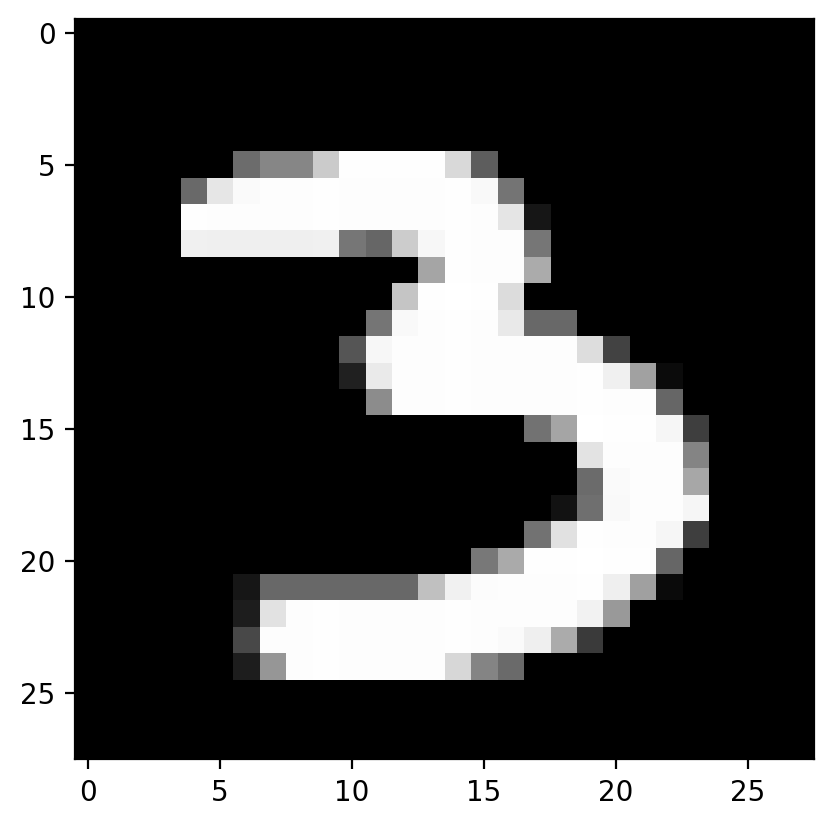

In [42]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## 2.2 Defining Neural Networks with PyTorch

PyTorch provides a module `nn` that makes building networks much simpler. There are two ways you can use the `nn` module to define your network: using `nn.Module` and using `nn.Sequential`

In [43]:
from torch import nn

### Using `nn.Module`:

This method defines the model as a subclass form the `nn.Module` class.

In [ ]:
# First Method: 

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        #28x28 = 784
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x
    
model = Network()

Let's go through the first method bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with the parent class constructor `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here I defined operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor `x` is passed through each operation and reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [45]:
# Create the network and look at its text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

You can define the network somewhat more concisely and clearly using the `torch.nn.functional` module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as `F`, `import torch.nn.functional as F`.

In [46]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=-1)
        
        return x

In [47]:
model = Network()

### Using `nn.Sequential`:

PyTorch provides a convenient way to build networks where a tensor is passed sequentially through operations without subclassing the `nn.Module`, it's called `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). This method is more concise and easier to read but less flexible if you need to add more complex operations or multiple inputs/outputs in the future.

In [48]:
import torch.nn as nn

# Define the network using nn.Sequential
model = nn.Sequential(
    nn.Linear(784, 256),      # Input layer to hidden layer
    nn.Sigmoid(),             # Sigmoid activation
    nn.Linear(256, 10),       # Hidden layer to output layer
    nn.Softmax(dim=-1)         # Softmax activation for output
)

### Initializing weights and biases

The weights and biases are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [49]:
print(model[0].weight)
print(model[0].bias)

Parameter containing:
tensor([[ 0.0101, -0.0333, -0.0292,  ...,  0.0340, -0.0024,  0.0275],
        [-0.0251, -0.0146,  0.0267,  ...,  0.0090,  0.0292,  0.0158],
        [-0.0111,  0.0123,  0.0156,  ..., -0.0178, -0.0217,  0.0054],
        ...,
        [-0.0308, -0.0303, -0.0016,  ..., -0.0212, -0.0136, -0.0239],
        [ 0.0272,  0.0055, -0.0145,  ...,  0.0003, -0.0225,  0.0024],
        [ 0.0120,  0.0146, -0.0279,  ...,  0.0047,  0.0149, -0.0074]],
       requires_grad=True)
Parameter containing:
tensor([ 1.7079e-02,  2.9317e-02, -7.6232e-03,  1.2387e-02, -1.2957e-02,
         1.0283e-02, -2.1910e-02,  1.5737e-02, -2.1645e-02,  1.9180e-02,
         1.8866e-02, -3.4473e-02,  1.8497e-02,  2.3065e-02,  6.3397e-03,
        -4.8850e-03,  1.5381e-02,  2.6140e-02, -2.0359e-02, -2.3857e-02,
        -1.4885e-03,  2.3388e-03,  8.0387e-03,  1.8345e-02, -6.0374e-03,
         2.6539e-02, -2.7457e-04, -1.8708e-02,  1.5471e-02,  1.4976e-02,
        -2.1109e-02, -3.4488e-02, -2.7159e-02, -1.6805e-0

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [50]:
# sample from random normal with standard dev = 0.01
model[0].weight.data.normal_(std=0.01)

tensor([[ 0.0011, -0.0031, -0.0174,  ..., -0.0095, -0.0124, -0.0035],
        [ 0.0028, -0.0117,  0.0003,  ...,  0.0024,  0.0100,  0.0153],
        [ 0.0029, -0.0135, -0.0252,  ..., -0.0090, -0.0264,  0.0172],
        ...,
        [-0.0090, -0.0034, -0.0189,  ..., -0.0086, -0.0056, -0.0120],
        [ 0.0009,  0.0177,  0.0080,  ..., -0.0084,  0.0128, -0.0189],
        [ 0.0100, -0.0021,  0.0032,  ...,  0.0057, -0.0100, -0.0090]])

### 2.3 Conducting a Forward pass

Now that we have defined our model, let's see what happens when we pass in an image.

In [51]:
# Grab a batch of data 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Resize images into a 1D vector, new shape is (batch size, image pixels) 
images.resize_(64, 784)

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx])

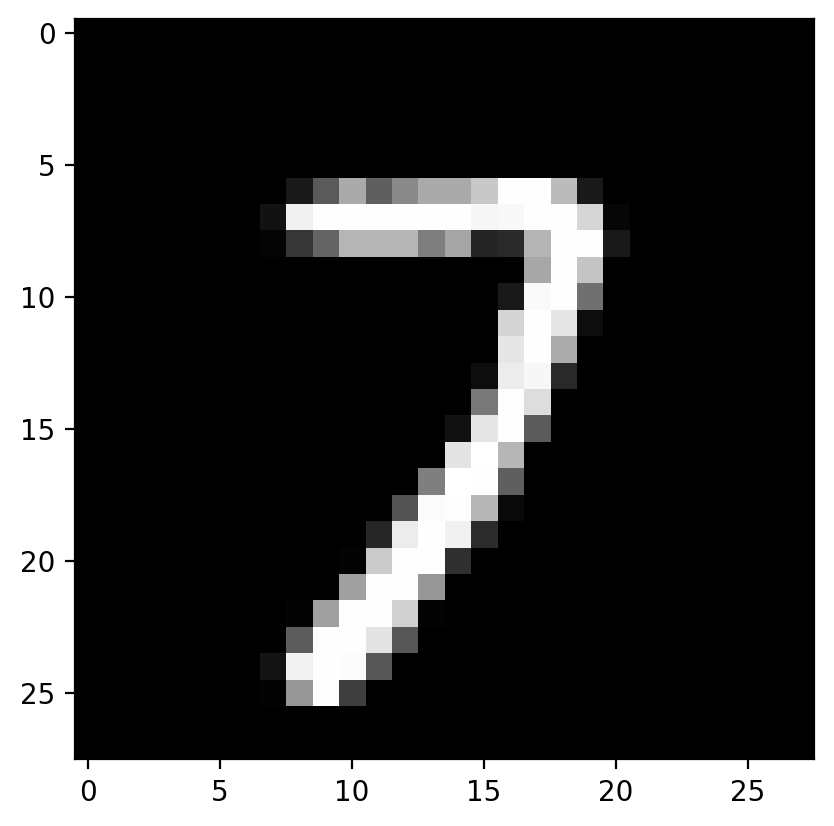

In [52]:
plt.imshow(images[img_idx].resize_(28,28).numpy().squeeze(), cmap='Greys_r');

In [53]:
ps.sum()

tensor(1.0000, grad_fn=<SumBackward0>)

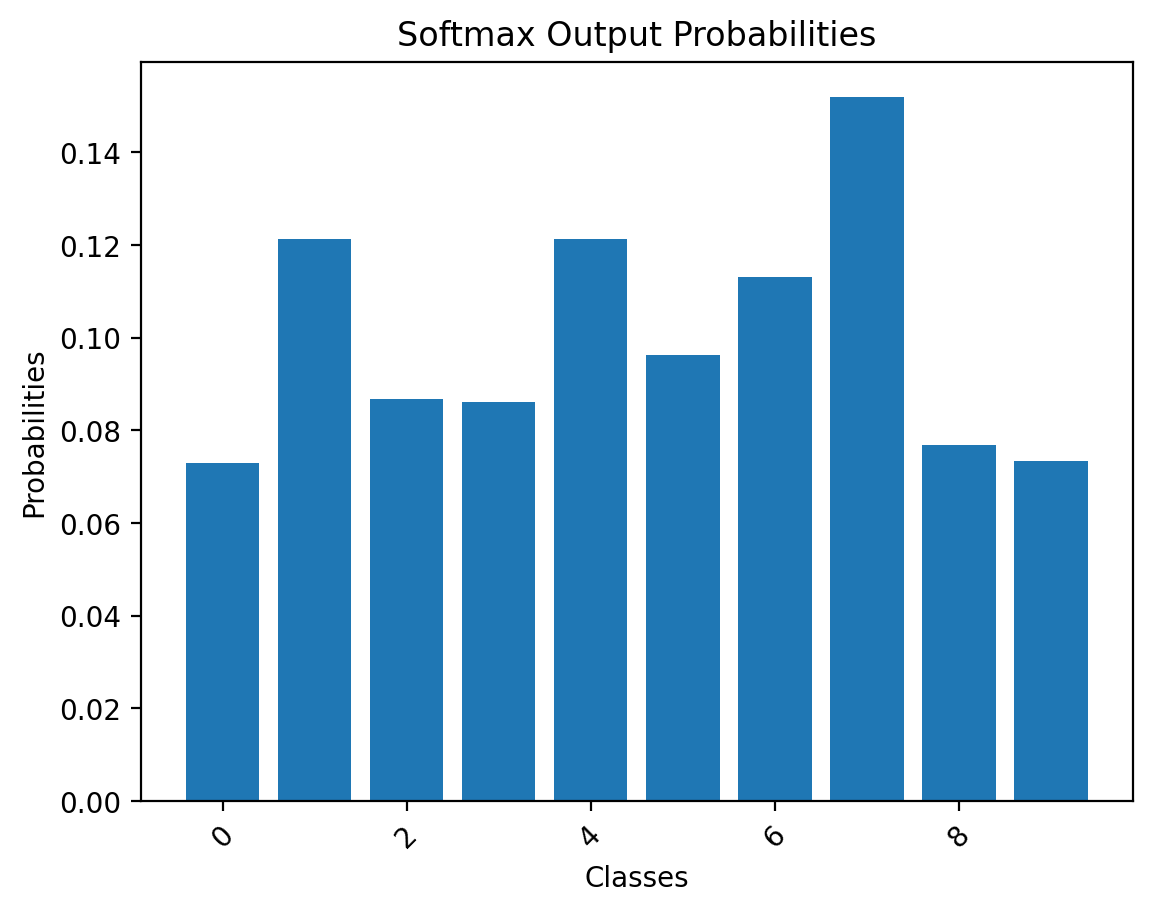

In [54]:
plt.bar(np.arange(ps.shape[0]), ps.detach().numpy())
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Softmax Output Probabilities')
plt.xticks(rotation=45)
plt.show()

Obviously, it's semi-random probabilities.

### Using `nn.Sequential`


In [55]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=-1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 784)
ps = model.forward(images[0,:])

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=-1)
)


In [56]:
ps

tensor([0.0777, 0.1196, 0.0962, 0.1194, 0.1045, 0.0898, 0.1071, 0.1067, 0.0911,
        0.0878], grad_fn=<SoftmaxBackward0>)

# Section 3: Training Neural Networks with Pytorch

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<center><img src="assets/function_approx.png" width=800px></center>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<center><img src='assets/gradient_descent.png' width=700px></center>

Training multilayer networks is done through **backpropagation** which is really just an application of the chain rule from calculus. We update each parameter (weights or biases) using the gradient of the loss with respect to that specific parameter, scaled by a learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## 3.1 Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to the name `criterion`. In a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> `nn.CrossEntropyLoss` combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to be the *logits* or *scores* for each class, therefore do not apply Softmax.

This means we need to pass in the raw output of our network into the `nn.CrossEntropyLoss`. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [57]:
## Using NLLLoss

# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=-1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our log-probabilities (logits)
logps = model(images)

# Calculate the loss with the logps and the labels
loss = criterion(logps, labels)

print(loss)

tensor(2.3142, grad_fn=<NllLossBackward0>)


In [58]:
## Using CrossEntropyLoss

# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our raw outputs
raw = model(images)

# Calculate the loss with the logps and the labels
loss = criterion(raw, labels)


print(loss)

tensor(2.2958, grad_fn=<NllLossBackward0>)


## 3.2 Autograd in Pytorch

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

As you will see below, the gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [59]:
# Assume this is your data
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.3707, -1.6232],
        [ 0.6222,  0.6825]], requires_grad=True)


In [60]:
# Assume this is the nerual network forward pass
y = x**2
print(y)

tensor([[0.1374, 2.6348],
        [0.3872, 0.4657]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [61]:
# Assume this is the loss calculation
z = y.mean()
print(z)

tensor(0.9063, grad_fn=<MeanBackward0>)


In [62]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [63]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.1853, -0.8116],
        [ 0.3111,  0.3412]])
tensor([[-0.1853, -0.8116],
        [ 0.3111,  0.3412]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step. 

## 3.3 Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [64]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))

# Flatten the images in the batch to 1D
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [65]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        [ 0.0025,  0.0025,  0.0025,  ...,  0.0025,  0.0025,  0.0025],
        [-0.0036, -0.0036, -0.0036,  ..., -0.0036, -0.0036, -0.0036],
        ...,
        [-0.0047, -0.0047, -0.0047,  ..., -0.0047, -0.0047, -0.0047],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003]])


## 3.4 Gradient Descent (Optimization) in Pytorch

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [66]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Clear the previous gradients
optimizer.zero_grad()

# Do Computations Using Model Parameters

# Use Backward to the loss calculate the gradients with respect to Model Parameters

# Take an update step to the Model Parameters
optimizer.step()

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [67]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 1.3471e-02,  2.3628e-02, -9.4894e-03,  ...,  4.0139e-03,
         -3.5176e-02, -2.4209e-02],
        [ 2.3440e-02,  2.8750e-02, -2.1843e-02,  ...,  2.0605e-02,
         -1.5202e-02, -1.7331e-02],
        [ 1.2091e-02,  2.9358e-02, -2.3561e-02,  ..., -1.8645e-02,
          3.4692e-02,  1.2142e-02],
        ...,
        [-3.5551e-02, -2.8062e-03, -1.8528e-02,  ...,  2.9826e-02,
          4.8549e-04, -2.9238e-02],
        [ 1.8325e-02,  2.5040e-02,  1.5074e-02,  ...,  3.1983e-02,
          1.2834e-02,  6.8745e-03],
        [-5.5641e-03, -3.0419e-02, -1.6833e-03,  ..., -7.0065e-05,
         -3.5133e-02,  2.2708e-02]], requires_grad=True)
Gradient - tensor([[ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003],
        [-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        ...,
        [ 0.0038,  0.0038,  0.0038,  ...,  0.0038,  0.0038,  0.0038],
   

In [68]:
# Take an update step and view the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 1.3462e-02,  2.3619e-02, -9.4981e-03,  ...,  4.0052e-03,
         -3.5185e-02, -2.4218e-02],
        [ 2.3438e-02,  2.8747e-02, -2.1846e-02,  ...,  2.0602e-02,
         -1.5204e-02, -1.7334e-02],
        [ 1.2103e-02,  2.9370e-02, -2.3550e-02,  ..., -1.8633e-02,
          3.4704e-02,  1.2154e-02],
        ...,
        [-3.5588e-02, -2.8440e-03, -1.8566e-02,  ...,  2.9788e-02,
          4.4768e-04, -2.9276e-02],
        [ 1.8317e-02,  2.5032e-02,  1.5066e-02,  ...,  3.1975e-02,
          1.2826e-02,  6.8665e-03],
        [-5.5655e-03, -3.0420e-02, -1.6847e-03,  ..., -7.1468e-05,
         -3.5134e-02,  2.2707e-02]], requires_grad=True)


## 3.5 Putting together the training loop!

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.


In [69]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.789094464484054
Training loss: 0.765156836175461
Training loss: 0.4979107547988261
Training loss: 0.4186868743696955
Training loss: 0.3807369442954501


C:\Users\Richard\AppData\Local\Temp\ipykernel_3396\3912703648.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(model.forward(images[img_idx]))


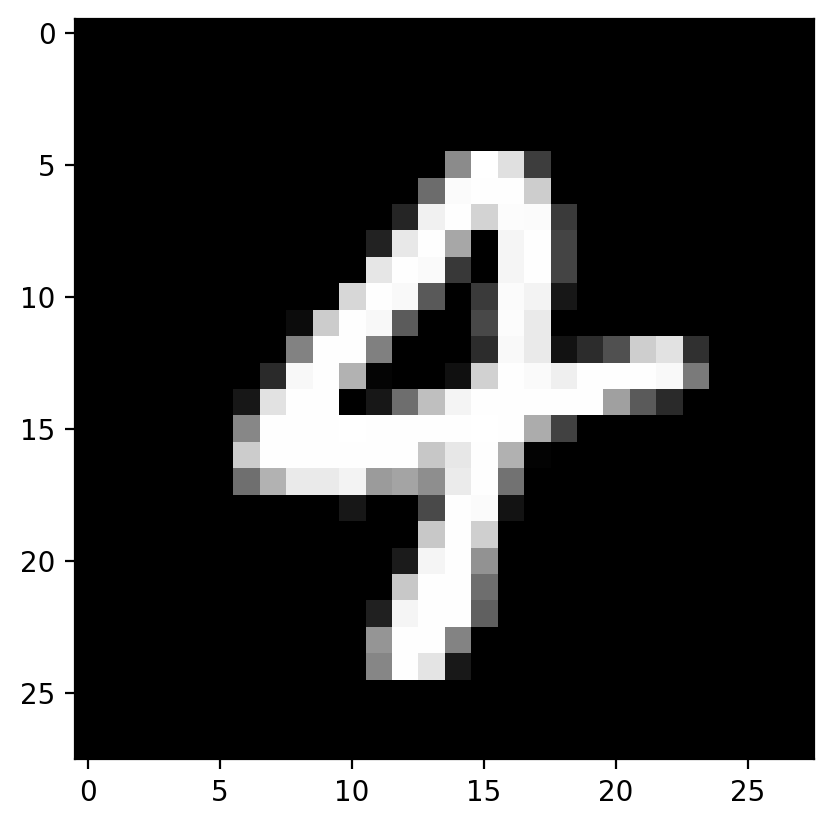

In [70]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Resize images into a 1D vector, new shape is (batch size, image pixels) 
images.resize_(64, 784)

# Forward pass through the network
img_idx = 0
ps = F.softmax(model.forward(images[img_idx]))

plt.imshow(images[img_idx].resize_(28,28).numpy().squeeze(), cmap='Greys_r');


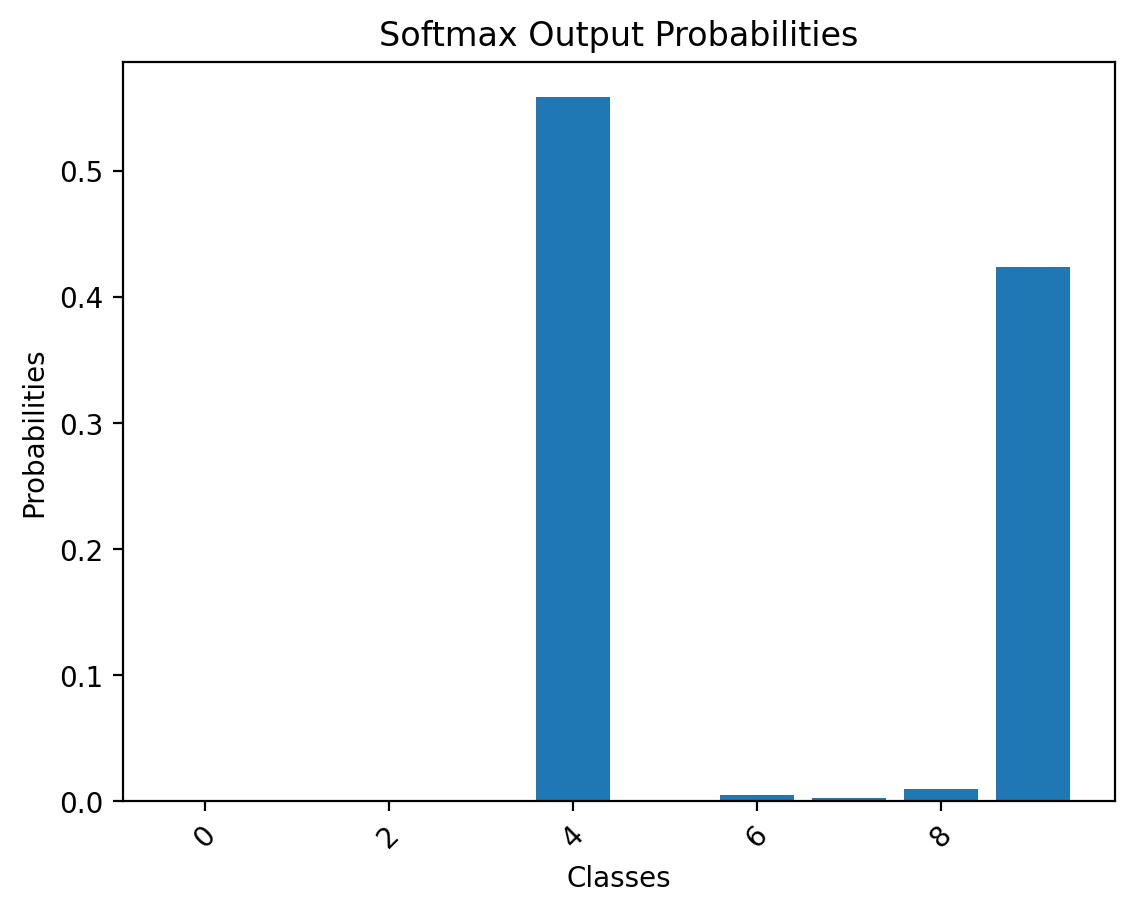

In [71]:
plt.bar(np.arange(ps.shape[0]), ps.detach().numpy())
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Softmax Output Probabilities')
plt.xticks(rotation=45)
plt.show()

# Section 4: Inference and Validation (Fashion-MNIST)

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. 


In this section, We'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

As usual, let's start by loading the dataset through torchvision. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.


<img src='assets/fashion-mnist-sprite.png' width=800px>


First off, let's load the dataset through torchvision.

In [72]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

print(trainset.classes)

100%|██████████| 26.4M/26.4M [00:04<00:00, 6.40MB/s]


Extracting C:\Users\Richard/.pytorch/F_MNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Richard/.pytorch/F_MNIST_data/FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 217kB/s]


Extracting C:\Users\Richard/.pytorch/F_MNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Richard/.pytorch/F_MNIST_data/FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 1.62MB/s]


Extracting C:\Users\Richard/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Richard/.pytorch/F_MNIST_data/FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting C:\Users\Richard/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Richard/.pytorch/F_MNIST_data/FashionMNIST\raw

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [73]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=-1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [74]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [75]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

In [76]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```
We have to convert the tensor to float.

In [77]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 9.375%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up the  by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

In [78]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 3

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        tot_train_loss += loss.item()
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/3..  Training Loss: 0.518..  Test Loss: 0.439..  Test Accuracy: 0.838
Epoch: 2/3..  Training Loss: 0.391..  Test Loss: 0.412..  Test Accuracy: 0.855
Epoch: 3/3..  Training Loss: 0.358..  Test Loss: 0.414..  Test Accuracy: 0.851


It takes lots of time to train! Normally, we use GPUs to accelerate the training process.

## 4.2 Accelerate the training using GPU

In [79]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Debug statement to check if GPU is enabled

# Instantiate model and move it to the device
model = Classifier()
model.to(device)  # Move model to GPU if available

# Define loss function and optimizer
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    
    for images, labels in trainloader:
        # Move data (images and labels) to GPU if available
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set

        # Turn off gradients for validation/testing
        with torch.no_grad():
            for images, labels in testloader:
                # Move test data to GPU if available
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                # Calculate accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Calculate mean losses for train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # Append losses to track training progress
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Print out the progress at the end of each epoch
        print(f"Epoch: {e+1}/{epochs}.. "
              f"Training Loss: {train_loss:.3f}.. "
              f"Test Loss: {test_loss:.3f}.. "
              f"Test Accuracy: {test_correct / len(testloader.dataset):.3f}")


Using device: cpu
Epoch: 1/10.. Training Loss: 0.515.. Test Loss: 0.458.. Test Accuracy: 0.836
Epoch: 2/10.. Training Loss: 0.394.. Test Loss: 0.415.. Test Accuracy: 0.852
Epoch: 3/10.. Training Loss: 0.358.. Test Loss: 0.397.. Test Accuracy: 0.855
Epoch: 4/10.. Training Loss: 0.336.. Test Loss: 0.414.. Test Accuracy: 0.858
Epoch: 5/10.. Training Loss: 0.317.. Test Loss: 0.391.. Test Accuracy: 0.860
Epoch: 6/10.. Training Loss: 0.300.. Test Loss: 0.390.. Test Accuracy: 0.869
Epoch: 7/10.. Training Loss: 0.294.. Test Loss: 0.363.. Test Accuracy: 0.872
Epoch: 8/10.. Training Loss: 0.281.. Test Loss: 0.388.. Test Accuracy: 0.861
Epoch: 9/10.. Training Loss: 0.274.. Test Loss: 0.380.. Test Accuracy: 0.872
Epoch: 10/10.. Training Loss: 0.267.. Test Loss: 0.376.. Test Accuracy: 0.874


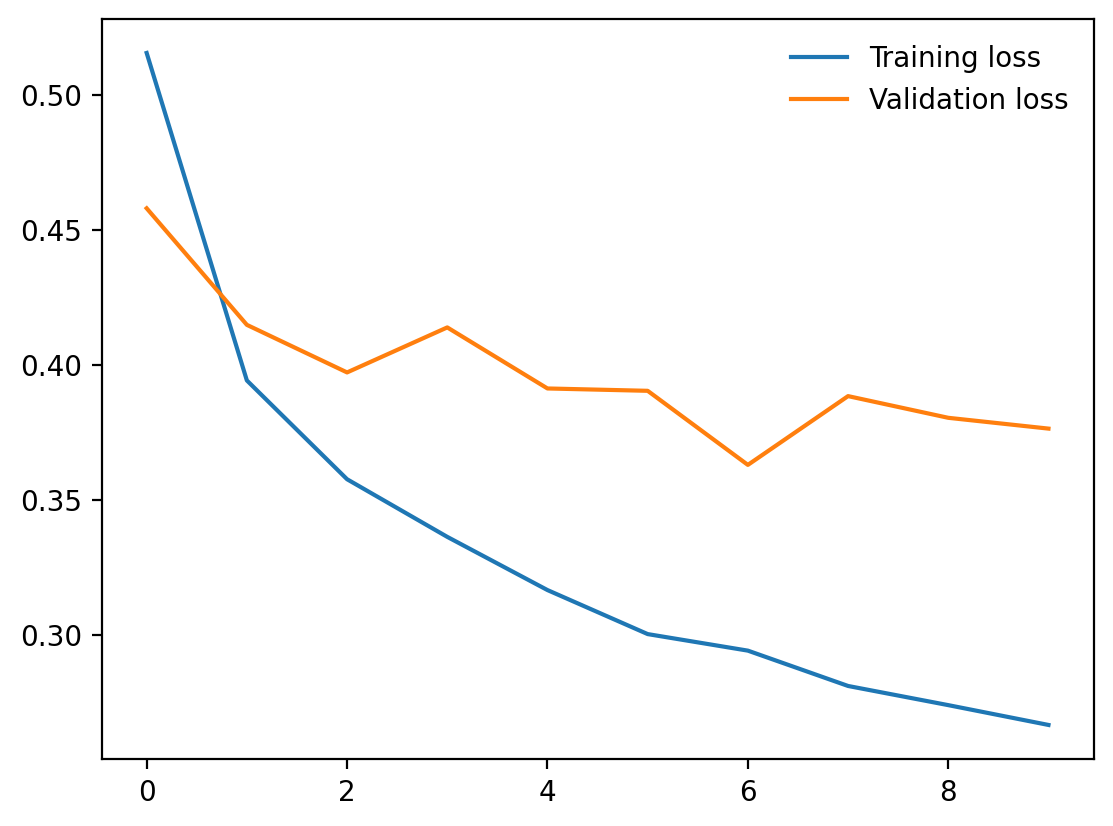

In [80]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)